# Vehicle Registration Trend Analysis

This notebook replicates and explains the analysis from `trend_analysis.py`, including outlier handling, time series decomposition, and prediction.


In [10]:
# Import libraries and set up output folder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
notebook_dir = pathlib.Path().resolve()
output_dir = os.path.join(notebook_dir, 'Advanced_Analysis', 'images')
os.makedirs(output_dir, exist_ok=True)

In [11]:
# Load cleaned data
# Fix: Use parent of notebook_dir to locate Dataset folder
dataset_dir = notebook_dir.parent / 'Dataset'
file_path = os.path.join(dataset_dir, 'Vehicle_Data_Cleaned.csv')
if not os.path.exists(file_path):
    file_path = os.path.join(dataset_dir, 'Vehicle_Data.csv')
df = pd.read_csv(file_path, low_memory=False)

In [12]:
# Parse registration date and aggregate monthly
if 'regvalidfrom' in df.columns:
    df['regvalidfrom'] = pd.to_datetime(df['regvalidfrom'], errors='coerce')
    df = df.dropna(subset=['regvalidfrom'])
    df['YearMonth'] = df['regvalidfrom'].dt.to_period('M')
    monthly_trend = df.groupby('YearMonth').size()
    monthly_trend.index = monthly_trend.index.to_timestamp()
    monthly_trend = monthly_trend[monthly_trend.index >= pd.Timestamp('2000-01-01')]
    summary_stats = monthly_trend.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
    display(summary_stats)

count      304.000000
mean      1699.983553
std       7800.455542
min          3.000000
1%          10.060000
5%          21.150000
25%        149.750000
50%        732.000000
75%       1389.000000
95%       2196.000000
99%      29782.160000
max      79193.000000
dtype: float64

In [13]:
# Outlier detection and capping
high_outlier_thresh = summary_stats['99%']
low_outlier_thresh = summary_stats['1%']
outlier_mask = (monthly_trend > high_outlier_thresh) | (monthly_trend < low_outlier_thresh)
num_outliers = outlier_mask.sum()
print(f'Outlier months detected: {num_outliers}')
monthly_trend_clean = monthly_trend.copy()
monthly_trend_clean[outlier_mask & (monthly_trend > high_outlier_thresh)] = high_outlier_thresh
monthly_trend_clean[outlier_mask & (monthly_trend < low_outlier_thresh)] = low_outlier_thresh

Outlier months detected: 8


C:\Users\asus\AppData\Local\Temp\ipykernel_22848\2440442374.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '29782.159999999232' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  monthly_trend_clean[outlier_mask & (monthly_trend > high_outlier_thresh)] = high_outlier_thresh


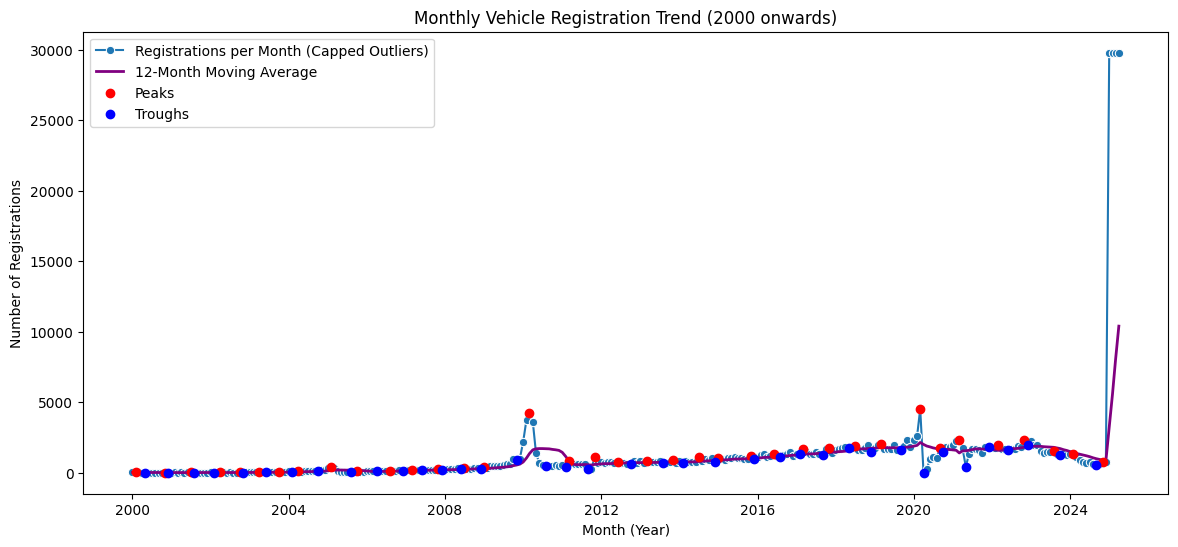

In [14]:
# Plot actual trend with moving average and peak/trough annotations
plt.figure(figsize=(14,6))
sns.lineplot(x=monthly_trend_clean.index, y=monthly_trend_clean.values, marker='o', label='Registrations per Month (Capped Outliers)')
ma = pd.Series(monthly_trend_clean.values).rolling(window=12, min_periods=1).mean()
plt.plot(monthly_trend_clean.index, ma, color='purple', linestyle='-', linewidth=2, label='12-Month Moving Average')
peaks, _ = find_peaks(monthly_trend_clean.values, distance=6)
troughs, _ = find_peaks(-monthly_trend_clean.values, distance=6)
plt.scatter(monthly_trend_clean.index[peaks], monthly_trend_clean.values[peaks], color='red', label='Peaks', zorder=5)
plt.scatter(monthly_trend_clean.index[troughs], monthly_trend_clean.values[troughs], color='blue', label='Troughs', zorder=5)
plt.title('Monthly Vehicle Registration Trend (2000 onwards)')
plt.xlabel('Month (Year)')
plt.ylabel('Number of Registrations')
plt.legend()
plt.show()

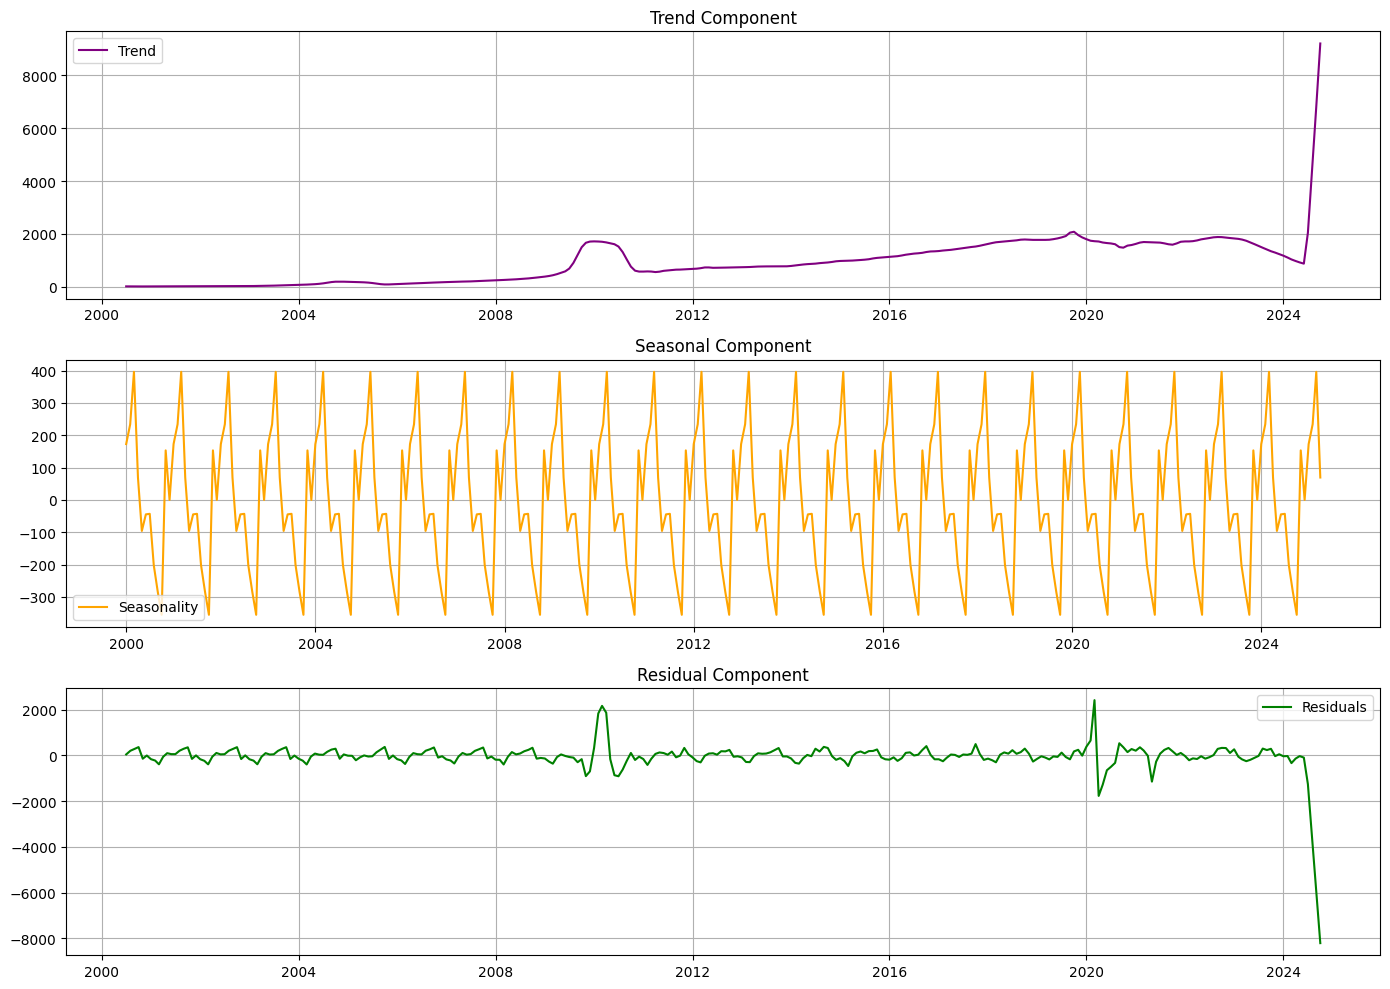

In [15]:
# Decompose trend (seasonal_decompose) and plot components
result = seasonal_decompose(monthly_trend_clean, model='additive', period=12)
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
axes[0].plot(result.trend.index, result.trend.values, label='Trend', color='purple')
axes[0].set_title('Trend Component')
axes[1].plot(result.seasonal.index, result.seasonal.values, label='Seasonality', color='orange')
axes[1].set_title('Seasonal Component')
axes[2].plot(result.resid.index, result.resid.values, label='Residuals', color='green')
axes[2].set_title('Residual Component')
for ax in axes: ax.legend(); ax.grid(True)
plt.tight_layout()
plt.show()

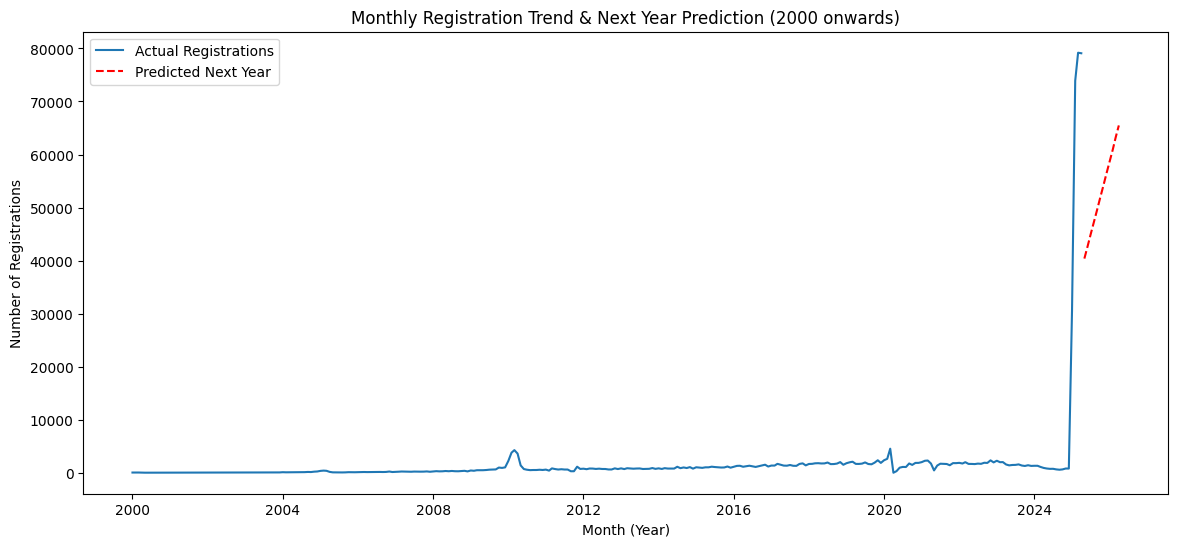

In [16]:
# Simple prediction: linear extrapolation (last 24 months)
months = np.arange(len(monthly_trend)).reshape(-1,1)
reg = LinearRegression()
reg.fit(months[-24:], monthly_trend.values[-24:])
future_months = np.arange(len(months), len(months)+12).reshape(-1,1)
future_preds = reg.predict(future_months)
future_index = pd.date_range(monthly_trend.index[-1]+pd.offsets.MonthBegin(), periods=12, freq='MS')
plt.figure(figsize=(14,6))
plt.plot(monthly_trend.index, monthly_trend.values, label='Actual Registrations')
plt.plot(future_index, future_preds, label='Predicted Next Year', linestyle='--', color='red')
plt.title('Monthly Registration Trend & Next Year Prediction (2000 onwards)')
plt.xlabel('Month (Year)')
plt.ylabel('Number of Registrations')
plt.legend()
plt.show()

Max registration date in data: 2025-04-30 00:00:00
Records after removing future dates: 517812
Exported cleaned monthly registration trend to: E:\Vehicle-Registration-Analysis\Notebook\Advanced_Analysis\images\monthly_registration_trend.csv


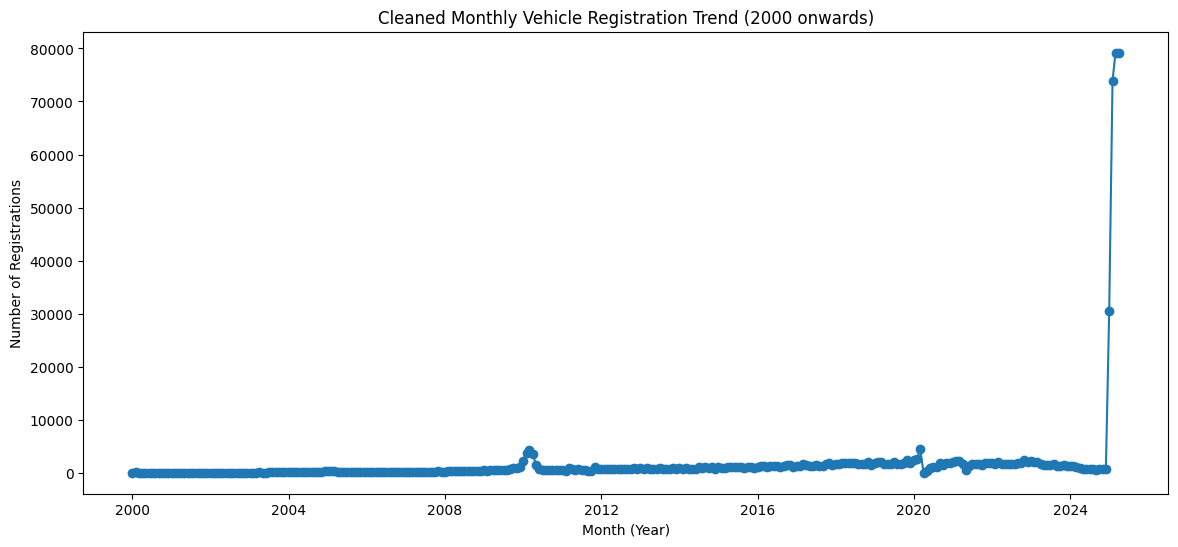

In [17]:
# --- Data Quality Check & Export ---
# 1. Check for future dates and abnormal spikes
# 2. Remove future dates and re-aggregate
# 3. Export cleaned monthly trend to CSV

# Step 1: Check for future dates
max_date = df['regvalidfrom'].max()
print(f'Max registration date in data: {max_date}')

# Step 2: Remove future dates (after today)
today = pd.Timestamp('now').normalize()
df_clean = df[df['regvalidfrom'] <= today].copy()
print(f'Records after removing future dates: {len(df_clean)}')

# Step 3: Re-aggregate monthly trend
monthly_trend_cleaned = df_clean.groupby(df_clean['regvalidfrom'].dt.to_period('M')).size()
monthly_trend_cleaned.index = monthly_trend_cleaned.index.to_timestamp()
monthly_trend_cleaned = monthly_trend_cleaned[monthly_trend_cleaned.index >= pd.Timestamp('2000-01-01')]

# Step 4: Export cleaned monthly trend
export_path = os.path.join(output_dir, 'monthly_registration_trend.csv')
monthly_trend_cleaned.to_csv(export_path, header=['Registrations'])
print(f'Exported cleaned monthly registration trend to: {export_path}')

# Optional: Plot cleaned trend for sanity check
plt.figure(figsize=(14,6))
plt.plot(monthly_trend_cleaned.index, monthly_trend_cleaned.values, marker='o')
plt.title('Cleaned Monthly Vehicle Registration Trend (2000 onwards)')
plt.xlabel('Month (Year)')
plt.ylabel('Number of Registrations')
plt.show()